In [1]:
# Import modules

%matplotlib notebook

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from obspy import UTCDateTime, read, read_inventory, read_events
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.header import FDSNNoDataException
from datetime import datetime, timedelta, timezone

import pandas as pd
from scipy.interpolate import interp1d
import os
import shutil

from time import time
import pickle

In [2]:
# Define the data directories

cwd = os.getcwd()
data_dir = os.path.join(cwd, "data")
raw_waveform_dir = os.path.join(data_dir, "waveforms_raw")
processed_waveform_dir = os.path.join(data_dir, "waveforms_proc_broadband")

In [10]:
# Remove the old directories and create new ones

if os.path.isdir(raw_waveform_dir):
    shutil.rmtree(raw_waveform_dir)
os.mkdir(raw_waveform_dir)

if os.path.isdir(processed_waveform_dir):
    shutil.rmtree(processed_waveform_dir)
os.mkdir(processed_waveform_dir)

# Station inventory and event catalogue

First, we define the parameters for the data acquisition. We take the catalogue from the Southern California Seismic Network (`CI`) from 2000 to 2015, and select all seismic stations and events recorded within a latitude range of 32$^{\circ}$ to 36$^{\circ}$, and within a longitude range of -120$^{\circ}$ to -116$^{\circ}$.

In [4]:
# Parameters

client = Client("IRIS")
network = "CI"  # Southern California Seismic Network

inventory_filename = "inventory.xml"
catalogue_filename = "catalogue.file"

starttime = UTCDateTime("2000-01-01T00:00:00")
endtime = UTCDateTime("2015-01-01T00:00:00")

station_settings = {
    "network": "CI",
    "minlatitude": 32,
    "maxlatitude": 36,
    "minlongitude": -120,
    "maxlongitude": -116,
    "startbefore": endtime,
    "endafter": starttime,
    "level": "response",
    "filename": inventory_filename,
    "format": "xml",
    "channel": "BHN,BHE,BHZ",
}

event_settings = {
    "minlatitude": 32,
    "maxlatitude": 36,
    "minlongitude": -120,
    "maxlongitude": -116,
    "starttime": starttime,
    "endtime": endtime,
    "minmagnitude": 3.0,
    "filename": catalogue_filename,
}

In [11]:
# Get seismic stations (may take a few minutes)

client.get_stations(**station_settings)

We create a Pandas dataframe with some useful station metadata:

In [5]:
# Read the stations
stations = read_inventory(inventory_filename).select(network=network)[0]
# Get the station codes (sort alphabetically)
station_codes = np.sort([station.code for station in stations])
# Define the dataframe
station_df = pd.DataFrame(columns=("code", "lat", "lon", "start_date", "end_date"))

# Loop over sorted station codes
for station_code in station_codes:
    # Select the station data
    station = stations.select(station=station_code)[0]
    # Append station metadata to dataframe
    station_df = station_df.append(
        {
            "code": station_code, 
            "lat": station.latitude, 
            "lon": station.longitude,
            "start_date": station.start_date,
            "end_date": station.end_date,
        }, ignore_index=True
    )

# Save dataframe to CSV
station_df.to_csv(os.path.join(data_dir, "stations.csv"), index=False)

As a quick sanity check, we plot the station locations:

187


<IPython.core.display.Javascript object>


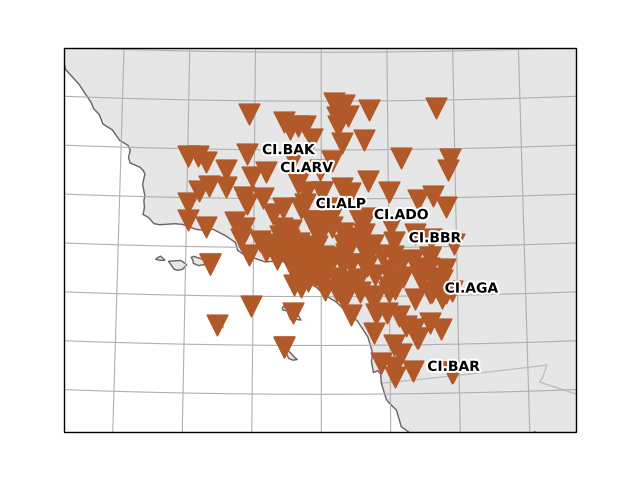

In [6]:
# Print out number of stations
print(len(station_df))
# Plot station locations
pl = stations.plot(projection="local", resolution="i", show=True)
plt.show()

Next, we download the SCSN event catalogue:

In [14]:
client.get_events(**event_settings)

In [7]:
# Read events from file
catalogue = read_events(catalogue_filename)
print(catalogue)

1386 Event(s) in Catalog:
2014-12-31T06:27:41.700000Z | +34.630, -118.623 | 3.1 ML
2014-12-30T23:26:17.810000Z | +33.576, -118.276 | 4.0 ML
...
2000-01-02T17:58:32.230000Z | +34.309, -116.081 | 3.2 ML
2000-01-01T03:58:38.570000Z | +34.835, -116.288 | 3.1 ML
To see all events call 'print(CatalogObject.__str__(print_all=True))'


Again, we plot some events just to check everything went as expected:

<IPython.core.display.Javascript object>


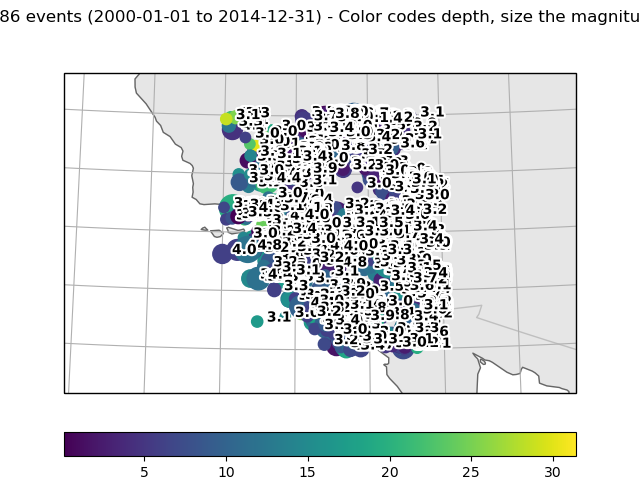

In [8]:
catalogue.plot(projection="local", resolution="i", show=True)
plt.show()

# Downloading the raw waveforms

In the cell below, we download the waveforms and create a lookup table for the stations that were operational at the time of the event. While looping over all events in the catalogue, we select the "preferred" origin time, location, and magnitude, and check which stations were operational around the origin time. We then download the three-component waveforms up to 120 seconds after the origin time for each operational station. 

**Note 1**: the "operational" stations have not necessarily recorded anything. We will do additional quality checking in a subsequent step.

**Note 2**: downloading the waveforms takes several hours with a fast internet connection.

In [9]:
# Initiate event catalogue dataframe
catalogue_df = pd.DataFrame(columns=("time", "lat", "lon", "depth", "mag"))
# Initiate station lookup table
catalogue_station_lookup = {}

t0 = time()
ETA = 0

# Loop over events in SCSN catalogue
for i, event in enumerate(catalogue):
    
    # Calculate ETA based on average processing time
    running_time = time() - t0
    events_per_sec = (i + 1) / running_time
    events_to_do = len(catalogue) - i
    ETA = events_to_do / events_per_sec
    
    print("Fetching event %d / %d [ETA: %.d s]" % (i+1, len(catalogue), ETA))
    
    # Check which event origin time/location and magnitude are preferred
    pref_origin = event.preferred_origin_id
    pref_magnitude = event.preferred_magnitude_id
    origins = event.origins
    magnitudes = event.magnitudes
    
    # Grab preferred origin
    for origin in origins:
        if origin.resource_id == pref_origin:
            break
    
    # Grab preferred magnitude
    for magnitude in magnitudes:
        if magnitude.resource_id == pref_magnitude:
            break
    
    # Append event to dataframe
    catalogue_df = catalogue_df.append(
        {"time": origin.time, "lat": origin.latitude, "lon": origin.longitude, "depth": origin.depth, "mag": magnitude.mag}, 
        ignore_index=True
    )
    
    # Waveform output file
    waveform_file = os.path.join(raw_waveform_dir, "%d.sac" % i)
    
    # Start and end time of waveforms
    start_trace = origin.time
    end_trace = origin.time + timedelta(seconds=120)
    
    # Check which stations were operational
    # Station commissioned before start time
    station_inds = (station_df["start_date"] < start_trace)
    # (and) station decommissioned after end time, or still operational
    station_inds = station_inds & ((station_df["end_date"] > end_trace) | station_df["end_date"].isnull())
    # Get station codes of operational stations
    operational_stations = np.sort(station_df["code"][station_inds].values)
    # Append operational stations to lookup table
    catalogue_station_lookup[i] = operational_stations
    
    # Generate query for requesting waveforms
    bulk_query = [(network, station, "*", "BH*", start_trace, end_trace) for station in operational_stations]
    
    print("Fetching data for %d stations" % len(operational_stations))
    
    # Get the data (if available) and write to output file
    try:
        client.get_waveforms_bulk(bulk_query, filename=waveform_file)
    # If FDSN complains: move on
    except FDSNNoDataException:
        print("No data...")
        continue

# Write event catalogue to CSV
catalogue_df.to_csv(os.path.join(data_dir, "catalogue.csv"))

# Write lookup table to binary object
lookup_file = os.path.join(data_dir, "catalogue_station_lookup.pickle")
with open(lookup_file, "wb") as f:
    pickle.dump(catalogue_station_lookup, f, protocol=pickle.HIGHEST_PROTOCOL)

Fetching event 1 / 1386 [ETA: 2 s]
Fetching data for 166 stations
Fetching event 2 / 1386 [ETA: 6338 s]
Fetching data for 166 stations
Fetching event 3 / 1386 [ETA: 9438 s]
Fetching data for 166 stations
Fetching event 4 / 1386 [ETA: 8370 s]
Fetching data for 166 stations
Fetching event 5 / 1386 [ETA: 8961 s]
Fetching data for 166 stations
Fetching event 6 / 1386 [ETA: 9503 s]
Fetching data for 166 stations
Fetching event 7 / 1386 [ETA: 9915 s]
Fetching data for 166 stations
Fetching event 8 / 1386 [ETA: 10393 s]
Fetching data for 166 stations
Fetching event 9 / 1386 [ETA: 10419 s]
Fetching data for 166 stations
Fetching event 10 / 1386 [ETA: 10618 s]
Fetching data for 166 stations
Fetching event 11 / 1386 [ETA: 10815 s]
Fetching data for 166 stations
Fetching event 12 / 1386 [ETA: 10856 s]
Fetching data for 166 stations
Fetching event 13 / 1386 [ETA: 10835 s]
Fetching data for 166 stations
Fetching event 14 / 1386 [ETA: 10965 s]
Fetching data for 166 stations
Fetching event 15 / 1386 

KeyboardInterrupt: 

# Processing the waveforms

After downloading the raw waveforms, we pre-process them to serve as an input to the deep learning model. First we check for each station that its response is available. Then we filter the waveforms between 0.1 and 8 Hz and interpolate the data onto a common time base sampled at ~20 Hz.

**Note**: this again takes several hours

In [18]:
from obspy.core.util.obspy_types import ObsPyException

# Read in the event catalogue
catalogue_df = pd.read_csv(os.path.join(data_dir, "catalogue.csv"))
# Convert time to timestamp
catalogue_df["time"] = pd.to_datetime(catalogue_df["time"])

Ntrace = 3     # Number of waveform components
Nt = 2048      # Number of time elements
scale = 1e5    # Scaling factor for waveform amplitude

t0_ETA = time()
ETA = 0

# Buffer to event-station lookup table
catalogue_station_lookup_final = {}

# Loop over all events in the catalogue
for i, event in catalogue_df.iterrows():
    
    # Calculate ETA based on average processing time
    running_time = time() - t0_ETA
    events_per_sec = (i + 1) / running_time
    events_to_do = len(catalogue) - i
    ETA = events_to_do / events_per_sec
    
    print("Processing event %d / %d [ETA: %d s]" % (i+1, len(catalogue), ETA))
    
    # Define the raw waveform file
    event_file = os.path.join(raw_waveform_dir, "%d.sac" % i)
    # If the data file does not exist (due to FDSN error in previous step): skip
    if not os.path.isfile(event_file):
        print("Event %d not found" % (i + 1))
        continue
    
    # Select all operational stations
    operational_stations = catalogue_station_lookup[i]
    # Number of operational stations
    Nstations = len(operational_stations)
    
    # Read the waveforms from file
    data = read(event_file)
    
    # Create a common time base from 1 < t < 101 seconds after the origin time
    starttime = event["time"] + timedelta(seconds=1)
    endtime = starttime + timedelta(seconds=101)
    time_base = pd.date_range(starttime, endtime, periods=Nt).to_pydatetime()
    # Create time base to proper UTC time (including DST and such)
    timestamp_base = np.array([dt.replace(tzinfo=timezone.utc).timestamp() for dt in time_base])
    # Make time base relative to start time
    t0 = timestamp_base.min()
    t_int = timestamp_base - t0
    
    # Buffer for processed waveforms (default to NaN for later pruning)
    proc_data = np.zeros((Nstations, Nt, 3)) * np.nan
    
    # Loop over operational stations
    for k, station in enumerate(operational_stations):
        # Select data stream for current station
        stream = data.select(station=station)
        # Check if all 3 components are present (no more, no less)
        if len(stream) == Ntrace:
            # Subtract mean of the trace
            stream.detrend("simple") 
            # Check if we can remove the station response (doesn't always work)
            try:
                stream.remove_response(inventory=stations, zero_mean=True)
            # Sometimes the station response information is not available
            except ValueError:
                print("Response could not be removed")
                continue
            # Sometimes ObsPy throws a weird error
            except ObsPyException as e:
                print("Weird Obspy exception")
                continue
            # If everything went well, filter signals between 0.1 and 8 Hz
            stream.filter("bandpass", freqmin=0.1, freqmax=8.0, zerophase=True)
            # Loop over waveform components
            for n in range(Ntrace):
                # Extract component
                trace = stream[n]
                tr_data = trace.data
                # Subtract mean (just in case)
                tr_data -= tr_data.mean()
                # Multiply with arbitrary scale
                tr_data *= scale
                # Component time base
                t = trace.times(type="timestamp") - t0
                # Interpolate data onto common time base and store in buffer
                proc_data[k, :, n] = interp1d(t, tr_data, fill_value=0, bounds_error=False, assume_sorted=True)(t_int)
    
    # Check which stations have valid data (i.e. which rows in proc_data are not NaN)
    ok_inds = np.isfinite(proc_data[:, 0, 0])
    # Append the stations that have valid data to lookup table
    catalogue_station_lookup_final[i] = operational_stations[ok_inds]
    # Define processed waveform output file
    proc_data_file = os.path.join(processed_waveform_dir, "%d.npy" % i)
    # Write output file
    np.save(proc_data_file, proc_data[ok_inds])

# Write lookup table to disk
lookup_file = os.path.join(data_dir, "catalogue_station_lookup_final.pickle")
with open(lookup_file, "wb") as f:
    pickle.dump(catalogue_station_lookup_final, f, protocol=pickle.HIGHEST_PROTOCOL)

Processing event 1 / 1386 [ETA: 14 s]
Processing event 2 / 1386 [ETA: 1454 s]
Processing event 3 / 1386 [ETA: 1764 s]
Processing event 4 / 1386 [ETA: 1918 s]
Processing event 5 / 1386 [ETA: 2023 s]
Processing event 6 / 1386 [ETA: 2103 s]
Processing event 7 / 1386 [ETA: 2140 s]
Processing event 8 / 1386 [ETA: 2185 s]
Processing event 9 / 1386 [ETA: 2219 s]
Processing event 10 / 1386 [ETA: 2248 s]
Processing event 11 / 1386 [ETA: 2269 s]
Processing event 12 / 1386 [ETA: 2287 s]
Processing event 13 / 1386 [ETA: 2301 s]
Processing event 14 / 1386 [ETA: 2315 s]
Processing event 15 / 1386 [ETA: 2321 s]
Processing event 16 / 1386 [ETA: 2326 s]
Processing event 17 / 1386 [ETA: 2330 s]
Processing event 18 / 1386 [ETA: 2323 s]
Processing event 19 / 1386 [ETA: 2316 s]
Processing event 20 / 1386 [ETA: 2312 s]
Processing event 21 / 1386 [ETA: 2309 s]
Processing event 22 / 1386 [ETA: 2306 s]
Processing event 23 / 1386 [ETA: 2306 s]
Processing event 24 / 1386 [ETA: 2297 s]
Processing event 25 / 1386 

Processing event 199 / 1386 [ETA: 2177 s]
Processing event 200 / 1386 [ETA: 2176 s]
Processing event 201 / 1386 [ETA: 2174 s]
Processing event 202 / 1386 [ETA: 2173 s]
Processing event 203 / 1386 [ETA: 2171 s]
Processing event 204 / 1386 [ETA: 2170 s]
Processing event 205 / 1386 [ETA: 2168 s]
Processing event 206 / 1386 [ETA: 2167 s]
Processing event 207 / 1386 [ETA: 2165 s]
Processing event 208 / 1386 [ETA: 2163 s]
Processing event 209 / 1386 [ETA: 2162 s]
Processing event 210 / 1386 [ETA: 2160 s]
Processing event 211 / 1386 [ETA: 2159 s]
Processing event 212 / 1386 [ETA: 2157 s]
Processing event 213 / 1386 [ETA: 2156 s]
Processing event 214 / 1386 [ETA: 2154 s]
Processing event 215 / 1386 [ETA: 2153 s]
Processing event 216 / 1386 [ETA: 2151 s]
Processing event 217 / 1386 [ETA: 2149 s]
Processing event 218 / 1386 [ETA: 2148 s]
Processing event 219 / 1386 [ETA: 2146 s]
Processing event 220 / 1386 [ETA: 2144 s]
Processing event 221 / 1386 [ETA: 2142 s]
Processing event 222 / 1386 [ETA: 

Processing event 395 / 1386 [ETA: 2701 s]
Processing event 396 / 1386 [ETA: 2713 s]
Processing event 397 / 1386 [ETA: 2725 s]
Processing event 398 / 1386 [ETA: 2738 s]
Processing event 399 / 1386 [ETA: 2750 s]
Processing event 400 / 1386 [ETA: 2762 s]
Processing event 401 / 1386 [ETA: 2774 s]
Processing event 402 / 1386 [ETA: 2784 s]
Processing event 403 / 1386 [ETA: 2795 s]
Processing event 404 / 1386 [ETA: 2806 s]
Processing event 405 / 1386 [ETA: 2817 s]
Processing event 406 / 1386 [ETA: 2827 s]
Processing event 407 / 1386 [ETA: 2838 s]
Processing event 408 / 1386 [ETA: 2848 s]
Processing event 409 / 1386 [ETA: 2859 s]
Processing event 410 / 1386 [ETA: 2870 s]
Processing event 411 / 1386 [ETA: 2882 s]
Processing event 412 / 1386 [ETA: 2893 s]
Processing event 413 / 1386 [ETA: 2904 s]
Processing event 414 / 1386 [ETA: 2915 s]
Processing event 415 / 1386 [ETA: 2925 s]
Processing event 416 / 1386 [ETA: 2935 s]
Processing event 417 / 1386 [ETA: 2944 s]
Processing event 418 / 1386 [ETA: 

Processing event 591 / 1386 [ETA: 4278 s]
Processing event 592 / 1386 [ETA: 4281 s]
Processing event 593 / 1386 [ETA: 4284 s]
Processing event 594 / 1386 [ETA: 4287 s]
Processing event 595 / 1386 [ETA: 4289 s]
Processing event 596 / 1386 [ETA: 4292 s]
Processing event 597 / 1386 [ETA: 4295 s]
Processing event 598 / 1386 [ETA: 4298 s]
Processing event 599 / 1386 [ETA: 4299 s]
Processing event 600 / 1386 [ETA: 4301 s]
Processing event 601 / 1386 [ETA: 4302 s]
Processing event 602 / 1386 [ETA: 4304 s]
Processing event 603 / 1386 [ETA: 4306 s]
Processing event 604 / 1386 [ETA: 4309 s]
Processing event 605 / 1386 [ETA: 4311 s]
Processing event 606 / 1386 [ETA: 4313 s]
Processing event 607 / 1386 [ETA: 4316 s]
Processing event 608 / 1386 [ETA: 4317 s]
Processing event 609 / 1386 [ETA: 4319 s]
Processing event 610 / 1386 [ETA: 4321 s]
Processing event 611 / 1386 [ETA: 4323 s]
Processing event 612 / 1386 [ETA: 4323 s]
Processing event 613 / 1386 [ETA: 4325 s]
Processing event 614 / 1386 [ETA: 

Processing event 787 / 1386 [ETA: 4075 s]
Processing event 788 / 1386 [ETA: 4071 s]
Processing event 789 / 1386 [ETA: 4066 s]
Processing event 790 / 1386 [ETA: 4061 s]
Processing event 791 / 1386 [ETA: 4056 s]
Processing event 792 / 1386 [ETA: 4051 s]
Processing event 793 / 1386 [ETA: 4046 s]
Processing event 794 / 1386 [ETA: 4041 s]
Processing event 795 / 1386 [ETA: 4036 s]
Processing event 796 / 1386 [ETA: 4031 s]
Processing event 797 / 1386 [ETA: 4026 s]
Processing event 798 / 1386 [ETA: 4021 s]
Processing event 799 / 1386 [ETA: 4016 s]
Processing event 800 / 1386 [ETA: 4011 s]
Processing event 801 / 1386 [ETA: 4006 s]
Processing event 802 / 1386 [ETA: 4001 s]
Processing event 803 / 1386 [ETA: 3996 s]
Processing event 804 / 1386 [ETA: 3990 s]
Processing event 805 / 1386 [ETA: 3985 s]
Processing event 806 / 1386 [ETA: 3980 s]
Processing event 807 / 1386 [ETA: 3978 s]
Processing event 808 / 1386 [ETA: 3975 s]
Processing event 809 / 1386 [ETA: 3973 s]
Processing event 810 / 1386 [ETA: 

Processing event 983 / 1386 [ETA: 2916 s]
Processing event 984 / 1386 [ETA: 2907 s]
Processing event 985 / 1386 [ETA: 2898 s]
Processing event 986 / 1386 [ETA: 2889 s]
Processing event 987 / 1386 [ETA: 2880 s]
Processing event 988 / 1386 [ETA: 2871 s]
Processing event 989 / 1386 [ETA: 2862 s]
Processing event 990 / 1386 [ETA: 2853 s]
Processing event 991 / 1386 [ETA: 2844 s]
Processing event 992 / 1386 [ETA: 2836 s]
Processing event 993 / 1386 [ETA: 2827 s]
Processing event 994 / 1386 [ETA: 2818 s]
Processing event 995 / 1386 [ETA: 2809 s]
Processing event 996 / 1386 [ETA: 2800 s]
Processing event 997 / 1386 [ETA: 2791 s]
Processing event 998 / 1386 [ETA: 2783 s]
Processing event 999 / 1386 [ETA: 2774 s]
Processing event 1000 / 1386 [ETA: 2765 s]
Processing event 1001 / 1386 [ETA: 2756 s]
Processing event 1002 / 1386 [ETA: 2748 s]
Processing event 1003 / 1386 [ETA: 2739 s]
Processing event 1004 / 1386 [ETA: 2730 s]
Processing event 1005 / 1386 [ETA: 2721 s]
Processing event 1006 / 1386

Processing event 1173 / 1386 [ETA: 1396 s]
Processing event 1174 / 1386 [ETA: 1389 s]
Processing event 1175 / 1386 [ETA: 1382 s]
Processing event 1176 / 1386 [ETA: 1375 s]
Processing event 1177 / 1386 [ETA: 1368 s]
Processing event 1178 / 1386 [ETA: 1360 s]
Processing event 1179 / 1386 [ETA: 1353 s]
Processing event 1180 / 1386 [ETA: 1346 s]
Processing event 1181 / 1386 [ETA: 1339 s]
Processing event 1182 / 1386 [ETA: 1332 s]
Processing event 1183 / 1386 [ETA: 1325 s]
Processing event 1184 / 1386 [ETA: 1318 s]
Processing event 1185 / 1386 [ETA: 1311 s]
Processing event 1186 / 1386 [ETA: 1304 s]
Processing event 1187 / 1386 [ETA: 1297 s]
Processing event 1188 / 1386 [ETA: 1290 s]
Processing event 1189 / 1386 [ETA: 1282 s]
Processing event 1190 / 1386 [ETA: 1275 s]
Processing event 1191 / 1386 [ETA: 1268 s]
Processing event 1192 / 1386 [ETA: 1261 s]
Processing event 1193 / 1386 [ETA: 1254 s]
Processing event 1194 / 1386 [ETA: 1247 s]
Processing event 1195 / 1386 [ETA: 1240 s]
Processing 

Processing event 1364 / 1386 [ETA: 138 s]
Processing event 1365 / 1386 [ETA: 132 s]
Event 1365 not found
Processing event 1366 / 1386 [ETA: 126 s]
Processing event 1367 / 1386 [ETA: 120 s]
Processing event 1368 / 1386 [ETA: 114 s]
Processing event 1369 / 1386 [ETA: 108 s]
Processing event 1370 / 1386 [ETA: 101 s]
Processing event 1371 / 1386 [ETA: 95 s]
Processing event 1372 / 1386 [ETA: 89 s]
Processing event 1373 / 1386 [ETA: 83 s]
Processing event 1374 / 1386 [ETA: 77 s]
Processing event 1375 / 1386 [ETA: 71 s]
Processing event 1376 / 1386 [ETA: 65 s]
Processing event 1377 / 1386 [ETA: 59 s]
Processing event 1378 / 1386 [ETA: 53 s]
Processing event 1379 / 1386 [ETA: 47 s]
Processing event 1380 / 1386 [ETA: 41 s]
Processing event 1381 / 1386 [ETA: 35 s]
Processing event 1382 / 1386 [ETA: 29 s]
Processing event 1383 / 1386 [ETA: 23 s]
Processing event 1384 / 1386 [ETA: 17 s]
Processing event 1385 / 1386 [ETA: 11 s]
Processing event 1386 / 1386 [ETA: 5 s]


Plot the waveforms of the event with the largest magnitude as a quick check:

364 Unnamed: 0                                 364
time          2010-07-07 23:53:34.280000+00:00
lat                                    33.3809
lon                                   -116.505
depth                                     7000
mag                                        5.5
Name: 364, dtype: object
60.2071722331


<IPython.core.display.Javascript object>


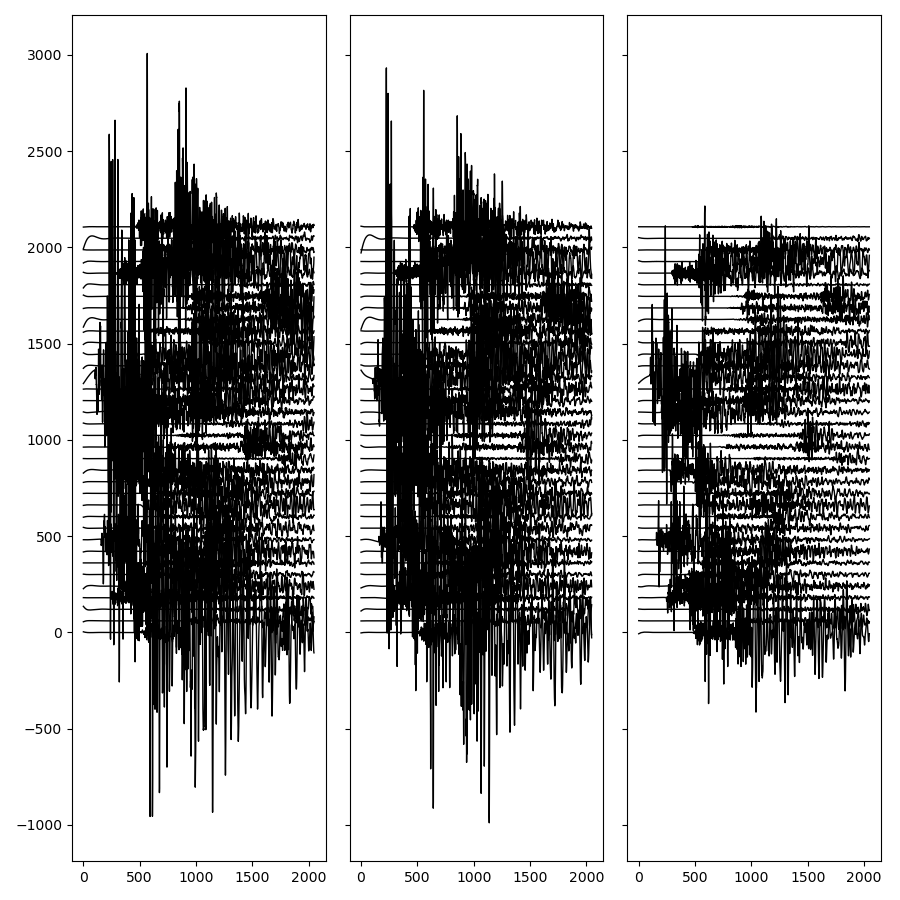

In [19]:
event_id = catalogue_df["mag"].idxmax()
print(event_id, catalogue_df.loc[event_id])
event_data = np.load(os.path.join(processed_waveform_dir, "%d.npy" % event_id))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 9), sharex="all", sharey="all")

for i, trace in enumerate(event_data):
    for j in range(Ntrace):
        if np.abs(trace[:, j].sum() == 0):
            axes[j].plot(trace[:, j] + i * event_data.std(), c="r", lw=1)
        else:
            axes[j].plot(trace[:, j] + i * event_data.std(), c="k", lw=1)

plt.tight_layout()
plt.show()